In [1]:
import matplotlib.pyplot as plt
plt.rc('font', family="Malgun Gothic")

In [2]:
import torch
from torch import nn, optim
from torch.optim.lr_scheduler import CosineAnnealingWarmRestarts
from transformers import MarianMTModel, MarianTokenizer # translation machine
import pandas as pd
from tqdm import tqdm
import math, random
from einops import rearrange

DEVICE = "cuda" if torch.cuda.is_available() else "CPU"
print(DEVICE)

c:\Users\hoya9\anaconda3\envs\torch-gpu\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


cuda


In [3]:
# for reproducibility
random_seed = 0
torch.manual_seed(random_seed)
torch.cuda.manual_seed(random_seed)
torch.cuda.manual_seed_all(random_seed) # Multi-GPU case
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
random.seed(random_seed)

In [4]:
# Load the tokenizer & model
tokenizer = MarianTokenizer.from_pretrained('Helsinki-NLP/opus-mt-ko-en')
model = MarianMTModel.from_pretrained('Helsinki-NLP/opus-mt-ko-en') # MT: Machine Translation

In [5]:
eos_idx = tokenizer.eos_token_id
pad_idx = tokenizer.pad_token_id
print('eos_idx = ', eos_idx)
print('pad_idx = ', pad_idx)

eos_idx =  0
pad_idx =  65000


## 하이퍼파라미터 조정

In [6]:
BATCH_SIZE = 64 # 실제 논문에선 2.5만 token이 한 batch에 담기게 했다고 함
LAMBDA = 0 # l2-Regularization를 위한 hyperparams (저장된 모델)
EPOCH = 15 # 저장된 모델
max_len = 100 # 길이 제한 (GPU 부담도 많이 감소)
"""
decoder에서 모델이 <eos>가 출력되는 것까지는 Loss를 구하고,
그뒤 <pad>에 대한 Loss는 무시하기 위한 역활
즉, label이 <pad> 일 때는 무시
"""
criterion = nn.CrossEntropyLoss(ignore_index=pad_idx)

scheduler_name = 'Noam' # Transformer 논문 제 2저자가 제안한 learning rate scheduler
scheduler_name = 'Cos'
#### Noam ####
# warmup_steps = 4000 # 실제 논문에서 제시한 값 (총 10만 step의 4%)
warmup_steps = 1000 # 데이터 수 * EPOCH / BS = 총 step 수 인것 고려 (저장된 모델)
LR_scale = .5 # Noam scheduler에 peak LR 값 조절을 위해 곱해질 값 (저장된 모델)
#### Cos ####
LR_init = 5e-4
T0 = 1500 # 첫 주기
T_mult = 2 # 배 만큼 주기가 길어짐 (1보다 큰 정수여야 함)
#############

"""
나만의 모델을 만들고 싶으면,
new_model_train = True
prev_model_use = False
"""
new_model_train = False
prev_model_use = True

!mkdir data

if prev_model_use:
    !gdown https://drive.google.com/uc?id=1bjbeWgqlVKJ9gzDcL1hfD9cIItQy9_N2 -O data/Transformer_small.pt
    !gdown https://drive.google.com/uc?id=1M0yYP2umxlwaAbk_iq5G_Z5y3qLu9Wet -O data/Transformer_small_history.pt

    save_model_path = 'data/Transformer_small.pt'
    save_history_path = 'data/Transformer_small_history.pt'
else:
    save_model=path = 'data/Transformer_small2.pt'
    save_history_path = 'data/Transformer_small2_history.pt'

A subdirectory or file data already exists.
Downloading...
From (original): https://drive.google.com/uc?id=1bjbeWgqlVKJ9gzDcL1hfD9cIItQy9_N2
From (redirected): https://drive.google.com/uc?id=1bjbeWgqlVKJ9gzDcL1hfD9cIItQy9_N2&confirm=t&uuid=28e461f6-e516-4fd4-8c8f-f1dca77b3f6a
To: c:\Users\hoya9\OneDrive\Desktop\torch-gpu\Workspace\Transformer-pytorch\data\Transformer_small.pt

  0%|          | 0.00/448M [00:00<?, ?B/s]
  0%|          | 524k/448M [00:00<02:42, 2.76MB/s]
  1%|          | 2.62M/448M [00:00<00:46, 9.63MB/s]
  1%|▏         | 6.29M/448M [00:00<00:25, 17.4MB/s]
  3%|▎         | 12.6M/448M [00:00<00:13, 31.4MB/s]
  4%|▎         | 16.3M/448M [00:00<00:14, 29.0MB/s]
  4%|▍         | 19.9M/448M [00:01<00:25, 17.1MB/s]
  5%|▌         | 22.5M/448M [00:01<00:27, 15.5MB/s]
  6%|▌         | 25.7M/448M [00:01<00:28, 14.8MB/s]
  6%|▌         | 27.8M/448M [00:01<00:26, 15.7MB/s]
  7%|▋         | 32.0M/448M [00:02<00:45, 9.12MB/s]
  8%|▊         | 37.2M/448M [00:02<00:29, 13.7MB/s]
  9%|▉

In [7]:
"""
논문에 나오는 BASE MODEL
train loss를 많이 줄이려면 많은 epoch이 요구됨.
test 성능도 높이려면 더 많은 데이터가 필요함
"""
n_layers = 6
d_model = 512
d_ff = 2048
n_heads = 8
drop_p = .1

# 좀 사이즈 줄인 모델 (훈련된 input_embedding, fc_out 사용하면 사용 불가)
n_layers = 3
d_model = 26
d_ff = 512
n_heads = 8
drop_p = .1

## 토크나이저 & 학습된 모델 써보기

In [8]:
# tokenizer 써보기 (_로 띄어쓰기를 나타낸다! 즉, _가 없으면 이어진 한 단어 : subword tokenizing)
# tokenizer에 대한 참고 자료: https://ratsgo.github.io/nlpbook/docs/preprocess/bpe/
print(tokenizer.tokenize("Hi, I'm Ian. ... a  a?"))
print(tokenizer.tokenize('a/b 1+2+3 2:1 a>b'))
print(tokenizer.tokenize('pretrained restart'))
print(tokenizer.tokenize('chatGPT'))
print(tokenizer.tokenize('The example is very good in our lecture'))
print(tokenizer.tokenize('한글은 어떻게 할까?'))
print(tokenizer.tokenize('확실히 띄어쓰기 기준으로 토크나이징을 하는 것 같진 않다.'))
print(tokenizer.tokenize('여러분 차례!'))

['▁H', 'i', ',', '▁I', "'", 'm', '▁I', 'an', '.', '▁', '...', '▁a', '▁a', '?']
['▁a', '/', 'b', '▁1', '+2', '+3', '▁2:', '1', '▁a', '>', 'b']
['▁p', 're', 'tra', 'in', 'ed', '▁re', 'st', 'art']
['▁ch', 'at', 'G', 'P', 'T']
['▁The', '▁', 'ex', 'am', 'ple', '▁is', '▁', 'very', '▁good', '▁in', '▁', 'our', '▁', 'le', 'c', 'ture']
['▁한', '글', '은', '▁어떻게', '▁할까', '?']
['▁확실히', '▁띄', '어', '쓰기', '▁기준으로', '▁토', '크', '나이', '징', '을', '▁하는', '▁것', '▁같', '진', '▁않다', '.']
['▁여러분', '▁차례', '!']


In [9]:
# print(tokenizer.get_vocab()) # tokenizer에 들어있는 모든 토큰과 토큰의 해당하는 번호를 dict으로 가짐
vocab_size = tokenizer.vocab_size
print((vocab_size))

# add_special_token은 <eos> 자동 붙여주는 것을 방지
print(tokenizer.encode('지능', add_special_tokens=False))   # string to index
print(tokenizer.encode('<pad>', add_special_tokens=False))  # <pad>는 65000
print(tokenizer.encode('</s>', add_special_tokens=False))   # <sos> or <eos>는 0
print(tokenizer.encode('He', add_special_tokens=False))
print(tokenizer.encode('he', add_special_tokens=False))     # 대소문자 다른 단어로 인식
print(tokenizer.tokenize('문장을 넣으면 tokenize해서 숫자로 바꾼다'))
print(tokenizer.encode('문장을 넣으면 tokenize해서 숫자로 바꾼다', add_special_tokens=False))
print(tokenizer.decode([204]))
print(tokenizer.decode([206]))
print(tokenizer.decode([210]))
print(tokenizer.decode(list(range(15)) + [65000, 65001, 65002, 65003]))

65001
[34359]
[65000]
[0]
[125]
[59]
['▁문장', '을', '▁넣으면', '▁to', 'k', 'en', 'ize', '해서', '▁숫자', '로', '▁바꾼', '다']
[13774, 51, 40068, 5, 1479, 1252, 5016, 969, 6635, 131, 30737, 161]
사람
으로
make
</s> <unk> ., the to of? and s a' in 들<pad> <unk> <unk> <unk>


In [10]:
# 사전 학습된 모델로 번역
input_text = "지금 너무 배고프다... 치킨먹고 싶다!"

input_tokens = tokenizer.encode(input_text, return_tensors="pt")    # 모델에서 weight와 행렬곱을 하기 위해 2차원 벡터로 변경경
translated_tokens = model.generate(input_tokens, max_new_tokens=max_len)    # max_len까지만 출력
translated_text = tokenizer.decode(translated_tokens[0], skip_special_tokens=True)  # <pad> </s> <unk> 같은 특수 토큰은 출력에서 제외외

print("입력:", input_text)
print("번역 결과:", translated_text)

입력: 지금 너무 배고프다... 치킨먹고 싶다!
번역 결과: I'm so hungry right now... and I want chicken!


In [11]:
# data download
# https://aihub.or.kr/aihubdata/data/view.do?currMenu=115&topMenu=100&aihubDataSe=realm&dataSetSn=126 데이터 경로
!gdown https://drive.google.com/uc?id=1r4ZnFJOStyBlNRx7snBQ-Iq2GNyJKL6t -O data/dialogue.xlsx
data = pd.read_excel('data/dialogue.xlsx')

Downloading...
From: https://drive.google.com/uc?id=1r4ZnFJOStyBlNRx7snBQ-Iq2GNyJKL6t
To: c:\Users\hoya9\OneDrive\Desktop\torch-gpu\Workspace\Transformer-pytorch\data\dialogue.xlsx

  0%|          | 0.00/9.57M [00:00<?, ?B/s]
  5%|▌         | 524k/9.57M [00:00<00:03, 2.77MB/s]
 27%|██▋       | 2.62M/9.57M [00:00<00:00, 9.51MB/s]
 77%|███████▋  | 7.34M/9.57M [00:00<00:00, 20.3MB/s]
100%|██████████| 9.57M/9.57M [00:00<00:00, 17.6MB/s]


In [12]:
print(data.shape)
print(data.head(3))

(100000, 7)
    대분류 소분류       상황  Set Nr.  발화자                            원문  \
0  비즈니스  회의  의견 교환하기        1  A-1   이번 신제품 출시에 대한 시장의 반응은 어떤가요?   
1  비즈니스  회의  의견 교환하기        1  B-1    판매량이 지난번 제품보다 빠르게 늘고 있습니다.   
2  비즈니스  회의  의견 교환하기        1  A-2  그렇다면 공장에 연락해서 주문량을 더 늘려야겠네요.   

                                                 번역문  
0  How is the market's reaction to the newly rele...  
1  The sales increase is faster than the previous...  
2  Then, we'll have to call the manufacturer and ...  


In [13]:
class CustomDataset(torch.utils.data.Dataset):
    def __init__(self, data):
        self.data = data

    def __len__(self):
        return self.data.shape[0]

    def __getitem__(self, idx):
        return self.data.loc[idx, '원문'], self.data.loc[idx, '번역문']

custom_DS = CustomDataset(data)

train_DS, val_DS, test_DS = torch.utils.data.random_split(custom_DS, [97000, 2000, 1000])
# 논문에서는 450만개 영, 독 문장 pair 사용

train_DL = torch.utils.data.DataLoader(train_DS, batch_size=BATCH_SIZE, shuffle=True)
val_DL = torch.utils.data.DataLoader(val_DS, batch_size=BATCH_SIZE, shuffle=True)
test_DL = torch.utils.data.DataLoader(test_DS, batch_size=BATCH_SIZE, shuffle=True)

print(len(train_DS))
print(len(val_DS))
print(len(test_DS))

97000
2000
1000


In [14]:
# test_DS 확인
i = 5
src_text, trg_text = test_DS[i]

print(f"인덱스: {test_DS.indices[i]}")   # 원본 데이터에서의 인덱스 추척
print(f"원문: {src_text}")
print(f"영문: {trg_text}")

인덱스: 19993
원문: 나도 그랬으면 좋겠지만 겨울까지 휴가 못 가.
영문: I wish I could, but I can't go on vacation until winter.


In [15]:
# train_DL TEST
for src_texts, trg_texts in train_DL:
    print(src_texts)
    print(trg_texts)
    print(len(src_texts))
    print(len(trg_texts))


    # 여러 문장에 대해서는 tokenizer.encode() 가 아닌 그냥 tokenizer()사용
    # add_special_tokens = True (default)면 <eos>를 붙임
    # truncation = True: max_len 보다 길면 끊음
    src = tokenizer(src_texts, padding=True, truncation=True, max_length=max_len, return_tensors='pt', add_special_tokens=False).input_ids
    # <sos>가 tokenizer에 따로 없어서 </s> 를 <sos> 로서 사용
    trg_texts = ['</s> '+ s for s in trg_texts]
    trg = tokenizer(trg_texts, padding=True, truncation=True, max_length=max_len, return_tensors='pt', add_special_tokens=True).input_ids

    print(src[:2])
    print(trg[:2])
    print(src.shape)
    print(trg.shape)
    print(trg[:,-1])    # 가장 마지막 단어를 보니 어떤 문장은 <eos> 로 끝이 났고 나머지는 <pad> 로 끝이 났다는 걸 볼 수 있음
    print(tokenizer.decode(trg[trg[:,-1]==eos_idx,:][0]))   # 가장 긴 문장들 중 첫 번째 문장 관찰
    print(trg[5,:-1])  # 디코더 입력
    print(trg[5,1:])   # 디코더 출력으로 나와야 할 label
    # 어차피 출력으로 pad token이 기다리고 있으니 loss에서 ignore로 인해 다 무시되므로 eos가 들어가도 상관없음

    break

('아메리카노 1잔과 샌드위치 1개를 내일 아침 제 방으로 가져다주세요.', '아닙니다, 바로 다음에 나올 음식을 손님께 드리도록 할게요.', '2인분 추가 주문하면 음식이 나오는 데 얼마나 걸릴까요?', '일러스트 프로그램은 추가로 설치를 하셔야 하는데, 30분 정도 시간이 걸릴 것입니다.', '여기 이 부분이요, 아까 설명해주신 거랑 좀 다른 것 같은데요?', '그 제품은 품절되어 현재 남은 물량이 없습니다.', '새 상품과 기존에 받으셨던 상품의 맞교환으로 진행해드리겠습니다.', '그러게, 심지어 더치페이를 얼마를 해야 하는지 계산도 해줘.', '판매하는 핸드폰 케이스 종류를 늘려야 할인지도 모르겠어요.', '응, 식구들도 일찍 집에서 나가서 나를 깨워줄 사람이 없었어.', '하지만 꼭 인기 있는 주인공만 출연하는 것 같아.', '혹시 기내에서 카드 결제도 가능한가요?', '이 수박은 먹을 수도 없으니 환불 부탁드립니다.', '생각보다 음료가 너무 써서 그런데 시럽을 좀 추가할 수 있을까요?', '새로 계약하기로 했던 거 어떻게 되어가고 있어요?', '신경이 많이 쓰여서 웃을 때도 크게 안 웃거든요.', '마음에 드셨다니 다행이네요, 20분 정도 걸리는데 괜찮으세요?', '지금 퇴근하는 시간이라 차가 많이 막히지 않을까?', '그러면 저희 방으로 치킨을 시켜주실 수 있나요?', '한 팩에 물티슈가 100매 정도 들어 있습니다.', '체크인 시간은 11시까지인데, 혹시 언제 오세요?', '11일은 저희 쪽에서 힘들 것 같으니, 12일로 할 수 있을까요?', '장대리, 이번 우수실적 명단에 포함된 것 축하해.', '이 절에 가려면 버스를 타고 한 시간을 가야 해.', '다른 지점보다 훨씬 저렴하네요. 오늘 아무 때나 방문해도 될까요?', '몇 년간 꾸준히 SNS 활동을 했으며 이전에 상품 리뷰를 작성한 경험이 있는 사람들을 우선순위로 뽑았습니다.', '그러게, 아까 길 물어봤을 때 거기서 5분만 걸어가면 보인다고 했는데 말이지.', '요즘은 로봇 청소기보다 

In [16]:
# 내가 쓸 train data 에 대해서 MarianMTmodel이 잘 번역하는지 확인
src_text, trg_text = test_DS[5]
print(f"입력: {src_text}")
print(f"정답: {trg_text}")

src = tokenizer.encode(src_text, return_tensors='pt', add_special_tokens=True)
# add_special_tokens = False 해보면 뭔가 이상하게 번역함 (학습 때 source에도 <eos>를 넣었단 증거?)
translated_tokens = model.generate(src, max_new_tokens=max_len)
translated_text = tokenizer.decode(translated_tokens[0], skip_special_tokens=False)

print(f"AI의 번역: {translated_text}")  # 디코더 첫 입력으로 <pad> 토큰을 넣었음. (<pad>를 <sos>로 사용)


입력: 나도 그랬으면 좋겠지만 겨울까지 휴가 못 가.
정답: I wish I could, but I can't go on vacation until winter.
AI의 번역: <pad> I wish I could, but I can't go on vacation until winter.</s>


## 모델 구현

### Multi-Head Attention

In [17]:
class MHA(nn.Module):
    def __init__(self, d_model, n_heads):
        super().__init__()

        self.n_heads = n_heads

        self.fc_q = nn.Linear(d_model, d_model)
        self.fc_k = nn.Linear(d_model, d_model)
        self.fc_v = nn.Linear(d_model, d_model)
        self.fc_o = nn.Linear(d_model, d_model)

        self.scale = torch.sqrt(torch.tensor(d_model / n_heads))

    def forward(self, Q, K, V, mask=None):

        Q = self.fc_q(Q) # 개단차
        K = self.fc_k(K)
        V = self.fc_v(V)

        Q = rearrange(Q, '개 단 (헤 차) -> 개 헤 단 차', 헤=self.n_heads) # 개단차 -> 개헤단차
        K = rearrange(K, '개 단 (헤 차) -> 개 헤 단 차', 헤=self.n_heads)
        V = rearrange(V, '개 단 (헤 차) -> 개 헤 단 차', 헤=self.n_heads)

        attention_score = Q @ K.transpose(-2,-1)/self.scale # 개헤단단

        if mask is not None:
            attention_score[mask] = -1e10

        attention_weights = torch.softmax(attention_score, dim=-1) # 개헤단단

        attention = attention_weights @ V # 개헤단차

        X = rearrange(attention, '개 헤 단 차 -> 개 단 (헤 차)') # 개헤단차 -> 개단차
        x = self.fc_o(X) # 개단차

        return x, attention_weights

class FeedForward(nn.Module):
    def __init__(self, d_model, d_ff, drop_p):
        super().__init__()

        self.linear = nn.Sequential(nn.Linear(d_model, d_ff),
                                    nn.ReLU(),
                                    nn.Dropout(drop_p), # 논문에는 명시하진 않았지만, overfitting에 취약한 부분이기 때문에 추가
                                    nn.Linear(d_ff, d_model))

    def forward(self, x):
        x = self.linear(x)
        return x

In [18]:
Q = torch.randn(1, 4, 6)    # 개단차
print(Q)

Q = rearrange(Q, '개 단 (헤 차) -> 개 헤 단 차', 헤=3)  # 개단차 -> 개헤단차
# 주의! (차 헤)로 해보면 나뉜 데이터가 또 다름. 차원의 수 6을 헤드의 수 3으로 쪼개는 것이므로 (헤 차) 가 맞다.
print(Q)
print(Q.shape)

x = rearrange(Q, '개 헤 단 차 -> 개 단 (헤 차)') # 개헤단차 -> 개단차
print(x)
print(x.shape)

tensor([[[ 0.2595, -0.4927, -0.4737, -0.2074, -1.9427, -1.7322],
         [-0.5939, -1.1785, -0.7656, -1.9260, -0.8876, -0.6519],
         [ 0.1413, -1.7858,  0.2259, -0.0683, -0.4737, -1.9399],
         [-1.4287, -0.6150,  0.4548,  0.8434,  1.2168, -0.7239]]])
tensor([[[[ 0.2595, -0.4927],
          [-0.5939, -1.1785],
          [ 0.1413, -1.7858],
          [-1.4287, -0.6150]],

         [[-0.4737, -0.2074],
          [-0.7656, -1.9260],
          [ 0.2259, -0.0683],
          [ 0.4548,  0.8434]],

         [[-1.9427, -1.7322],
          [-0.8876, -0.6519],
          [-0.4737, -1.9399],
          [ 1.2168, -0.7239]]]])
torch.Size([1, 3, 4, 2])
tensor([[[ 0.2595, -0.4927, -0.4737, -0.2074, -1.9427, -1.7322],
         [-0.5939, -1.1785, -0.7656, -1.9260, -0.8876, -0.6519],
         [ 0.1413, -1.7858,  0.2259, -0.0683, -0.4737, -1.9399],
         [-1.4287, -0.6150,  0.4548,  0.8434,  1.2168, -0.7239]]])
torch.Size([1, 4, 6])


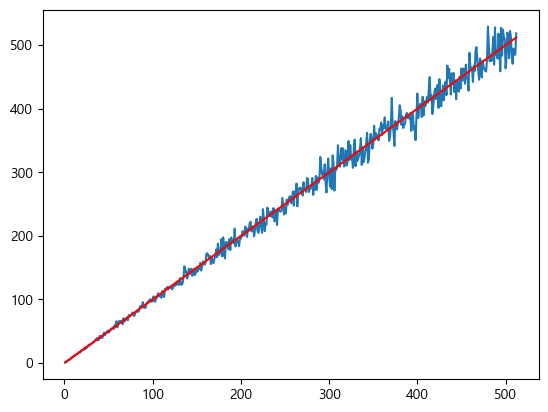

In [19]:
# scaling을 sqrt(dk)로 하는 이유 : 안나누면 softmax로 들어갈때 분산이 커져 grad가 작아짐
n = torch.arange(1, 513)
N = 1000
result = []
for ni in n:
    inner_prod = torch.zeros(N)
    for i in range(N):
        inner_prod[i] = torch.randn(ni,1).T@torch.randn(ni,1)   # inner product
    result += [torch.var(inner_prod)]

plt.plot(n,result)
plt.plot(n,n,'r') # 즉, dk가 커지면 variance도 같이 커지니깐 std(sqrt(dk))로 나눠서 dk가 함수가 아니도록 하는 것! (분산은 데이터 개수에 따라 값이 커지기도 하기 때문에)

### Encoder

In [20]:
class EncoderLayer(nn.Module):
    def __init__(self, d_model, d_ff, n_heads, drop_p):
        super().__init__()

        self.self_atten = MHA(d_model, n_heads)
        self.self_atten_LN = nn.LayerNorm(d_model)

        self.FF = FeedForward(d_model, d_ff, drop_p)
        self.FF_LN = nn.LayerNorm(d_model)

        self.dropout = nn.Dropout(drop_p)

    def forward(self, x, enc_mask):

        residual, atten_enc = self.self_atten(x, x, x, enc_mask) # pad masking
        residual = self.dropout(residual)
        x = self.self_atten_LN(x + residual)

        residual = self.FF(x)
        residual = self.dropout(residual)
        x = self.FF_LN(x + residual)

        return x, atten_enc

class Encoder(nn.Module):
    def __init__(self, input_embedding, max_len, n_layers, d_model, d_ff, n_heads, drop_p):
        super().__init__()
        """
        math pakage를 통한 scaler 값인 scale를 만들지 않고, 다음과 같이 구현해야 이유:
        1. torch.tensor()로 type 일치와 실제론 scaler지만 pytorch에서는 0차원 텐서로서 미분가능
        2. torch.sqrt()로 GPU연산가능
        """
        self.scale = torch.sqrt(torch.tensor(d_model))
        self.input_embedding = input_embedding
        self.pos_embedding = nn.Embedding(max_len, d_model)

        self.dropout = nn.Dropout(drop_p)

        self.layers = nn.ModuleList([EncoderLayer(d_model, d_ff, n_heads, drop_p) for _ in range(n_layers)])

    def forward(self, src, mask, atten_map_save=False): # src.shape = 개단, mask.shape = 개헤단단

        pos = torch.arange(src.shape[1]).expand_as(src).to(DEVICE)

        x = self.scale*self.input_embedding(src) + self.pos_embedding(pos)  # 개단차
        # self.scale를 곱해주면 position 보다 token 정보를 더 보게 된다. (gradient에 self.scale만큼이 더 곱해짐)
        x = self.dropout(x)

        atten_encs = torch.tensor([]).to(DEVICE)
        for layer in self.layers:
            x, atten_enc = layer(x, mask)
            if atten_map_save is True:
                atten_encs = torch.cat([atten_encs, atten_enc[0].unsqueeze(0)], dim=0)  # 층헤단단

        return x, atten_encs


#### expand_as, nn.embedding 실험

In [21]:
src = torch.randint(0,65000, (3,5)) # 개단
pos = torch.arange(5).expand_as(src).to(DEVICE)
print(src)
print(pos)

tensor([[17852, 30557, 14802,   783,  2753],
        [13780,  2814, 59476, 54905, 10648],
        [21454, 17110, 22480,  4393, 46681]])
tensor([[0, 1, 2, 3, 4],
        [0, 1, 2, 3, 4],
        [0, 1, 2, 3, 4]], device='cuda:0')


In [22]:
# nn.Embedding 실험
emb = nn.Embedding(10, 5) # one-hot encoding 된 벡터가 통과된다는 것이 약속된 상태의 FC layer
print(emb.weight.shape) # weight 개수는 nn.Linear(10, 5)와 동일! 단지 동작 방식이 다름
print(emb.weight)
print(emb(torch.tensor(2)))

print(emb(torch.tensor([[6,1,2],[2,1,7]]))) # 2개 문장, 3개 단어
print(emb(torch.tensor([[6,1,2],[2,1,7]])).shape)

torch.Size([10, 5])
Parameter containing:
tensor([[ 0.3053,  0.7740, -0.1448, -0.5994,  0.4004],
        [-0.5822, -0.3072, -0.9433, -2.7531, -0.0236],
        [-1.6781, -0.4184,  0.3999,  1.5914,  0.1325],
        [ 0.8183, -0.7544, -0.8827, -1.1778, -1.6542],
        [-1.3207, -0.6793,  0.1129, -1.0439, -0.4201],
        [ 0.0988,  0.6815,  1.1168, -0.6703, -0.7377],
        [-0.2685, -0.1505, -0.4780,  1.2038,  3.6673],
        [-0.0108,  0.2441,  2.3384, -0.9031, -0.9961],
        [-2.6855, -0.0280, -2.0526,  2.0998,  1.0727],
        [ 0.5224,  1.2706, -0.2532,  0.6647, -0.9538]], requires_grad=True)
tensor([-1.6781, -0.4184,  0.3999,  1.5914,  0.1325],
       grad_fn=<EmbeddingBackward0>)
tensor([[[-0.2685, -0.1505, -0.4780,  1.2038,  3.6673],
         [-0.5822, -0.3072, -0.9433, -2.7531, -0.0236],
         [-1.6781, -0.4184,  0.3999,  1.5914,  0.1325]],

        [[-1.6781, -0.4184,  0.3999,  1.5914,  0.1325],
         [-0.5822, -0.3072, -0.9433, -2.7531, -0.0236],
         [-0.0

In [23]:
atten_encs = torch.randn(2, 8, 10, 10)  # 개헤단단
atten_enc = torch.randn(1, 8, 10, 10)   # 개헤단단

print("기존 atten_encs 크기:", atten_encs.shape)
print("새로운 atten_enc[0] 크기:", atten_enc[0].shape)

# unsqueeze(0)로 차원 추가
new_attention = atten_enc[0].unsqueeze(0)
print("unsqueeze 후 크기:", new_attention.shape)

# torch.cat으로 연결
result = torch.cat([atten_encs, new_attention], dim=0)
print("최종 결과 크기:", result.shape)

기존 atten_encs 크기: torch.Size([2, 8, 10, 10])
새로운 atten_enc[0] 크기: torch.Size([8, 10, 10])
unsqueeze 후 크기: torch.Size([1, 8, 10, 10])
최종 결과 크기: torch.Size([3, 8, 10, 10])


### Decoder, 모델 전체

In [ ]:
class DecoderLayer(nn.Module):
    def __init__(self, d_model, d_ff, n_heads, drop_p):
        super().__init__()

        self.self_atten = MHA(d_model, n_heads)
        self.self_atten_LN = nn.LayerNorm(d_model)

        self.enc_dec_atten = MHA(d_model, n_heads)
        self.enc_dec_atten_LN = nn.LayerNorm(d_model)

        self.ff = FeedForward(d_model, d_ff, drop_p)
        self.ff_LN = nn.LayerNorm(d_model)

        self.dropout = nn.Dropout(drop_p)

    def forward(self, x, enc_out, dec_mask, enc_dec_mask):

        residual, atten_dec = self.self_atten(x, x, x, dec_mask)
        residual = self.dropout(residual)
        x = self.self_atten_LN(x + residual)

        residual, atten_enc_dec = self.enc_dec_atten(x, enc_out, enc_out, enc_dec_mask) # Q는 decoder로부터 K,V는 인코더로 부터
        residual = self.dropout(residual)
        x = self.enc_dec_atten_LN(x + residual)

        residual = self.ff(x)
        residual = self.dropout(residual)
        x = self.ff_LN(x + residual)

        return x, atten_dec, atten_enc_dec

